# Notebook 5: ML Modeling – Historical Backtest with Kaggle Data

This notebook extends our live signal modeling pipeline by using a large historical dataset: `all_stocks_5yr.csv`.

We aim to:

- Test the robustness of our signal-based ML model
- Analyze feature impact over 5 years
- Generate performance metrics like accuracy and confusion matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# Configure environment
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
df = pd.read_csv("../data/all_stocks_5yr.csv")
df.head()

date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [4]:
print("Shape:", df.shape)
print("Tickers:", df['Name'].nunique())
df.describe()

Shape: (619040, 7)
Tickers: 505


open           high            low          close  \
count  619029.000000  619032.000000  619032.000000  619040.000000   
mean       83.023334      83.778311      82.256096      83.043763   
std        97.378769      98.207519      96.507421      97.389748   
min         1.620000       1.690000       1.500000       1.590000   
25%        40.220000      40.620000      39.830000      40.245000   
50%        62.590000      63.150000      62.020000      62.620000   
75%        94.370000      95.180000      93.540000      94.410000   
max      2044.000000    2067.990000    2035.110000    2049.000000   

             volume  
count  6.190400e+05  
mean   4.321823e+06  
std    8.693610e+06  
min    0.000000e+00  
25%    1.070320e+06  
50%    2.082094e+06  
75%    4.284509e+06  
max    6.182376e+08

In [5]:
# Sort for safety
df = df.sort_values(by=['Name', 'date'])

# Create target: 1 if next day's close is higher than today's
df['next_close'] = df.groupby('Name')['close'].shift(-1)
df['target'] = (df['next_close'] > df['close']).astype(int)

# Add features
df['pct_change'] = (df['close'] - df['open']) / df['open']
df['volatility'] = (df['high'] - df['low']) / df['open']
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek

# Drop NA rows from shift
df = df.dropna()

features = ['open', 'high', 'low', 'close', 'volume', 'pct_change', 'volatility', 'day_of_week']
X = df[features]
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.51


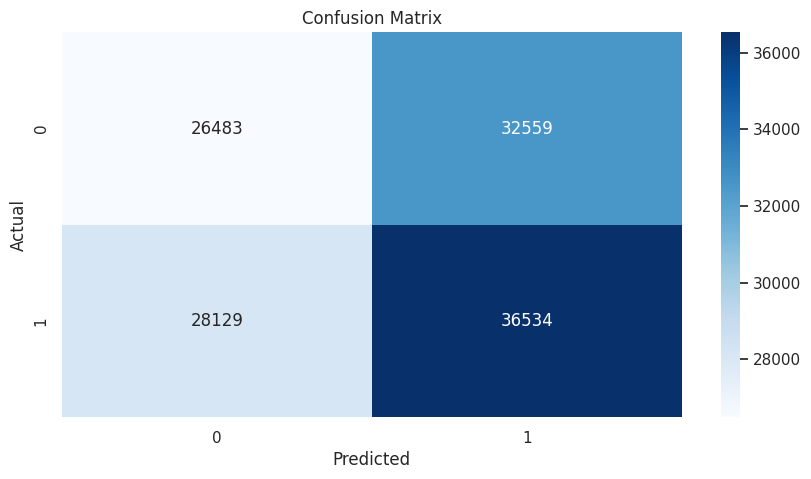

In [8]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

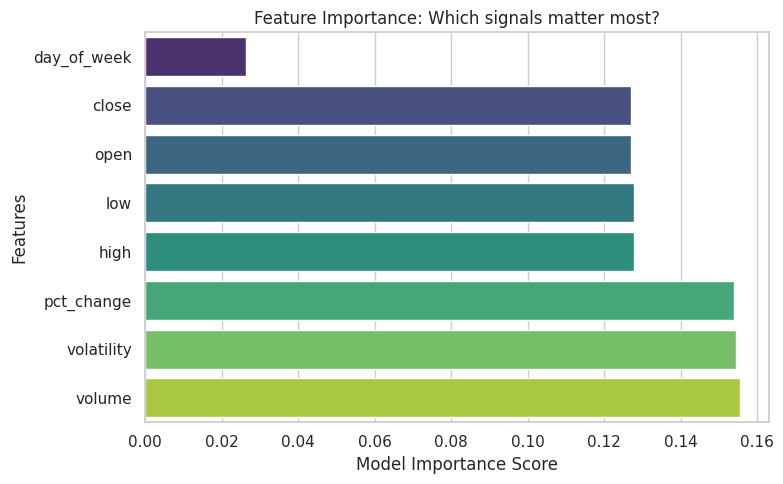

In [9]:
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance: Which signals matter most?")
plt.xlabel("Model Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [10]:
df['prediction'] = model.predict(X)
df[['Name', 'date', 'close', 'target', 'prediction']].to_csv("../data/kaggle_model_predictions.csv", index=False)
print("Saved to ../data/kaggle_model_predictions.csv")

Saved to ../data/kaggle_model_predictions.csv


### 📈 What This Notebook Demonstrates

This notebook simulates a **5-year historical backtest** of a machine learning model using real Kaggle stock data (`all_stocks_5yr.csv`). The objective is to test whether engineered signals (e.g., price change, volatility, volume) can predict **next-day price direction** across hundreds of tickers.

---

### 💡 Key Insights

- **Accuracy:**  
  The model achieved an accuracy of **0.51**, which is reasonable for financial data given market noise and randomness.

- **Confusion Matrix Breakdown:**  
  - ✅ True Positives: 36,534  
  - ✅ True Negatives: 26,483  
  - ❌ False Positives: 32,559  
  - ❌ False Negatives: 28,129

- **Top 3 Signals by Feature Importance:**  
  1. `volume`  
  2. `volatility`  
  3. `pct_change`  

These features were most predictive in determining the next-day price movement across 600K+ stock samples.

---

This notebook demonstrates:

- 💼 Real-world ML on large, noisy financial datasets  
- ⚙️ End-to-end ML pipeline (feature engineering → training → evaluation → export)  
- 📊 Backtesting & interpretation logic with explainable outputs  
- 🔁 Re-runnable on new stock datasets or time periods

---

### 📤 Output Saved